# Rap Music Analysis

In [1]:
import urllib.request
import urllib.parse
import urllib.error
from urllib.request import Request, urlopen
import requests

from bs4 import BeautifulSoup

import pandas as pd
import json

import string

In [2]:
# Create an empty DataFrame
column_names = ['Title','Artist','Lyrics','Comments']
df = pd.DataFrame(columns = column_names)

In [3]:
def request_artist_info(artist_name, page):
    
#     import getpass
    base_url = 'https://api.genius.com'
#     token = getpass.getpass('Enter your Genius API token:')
    
    headers = {'Authorization': 'Bearer ' + 'Mye9LRmSyay_Tp_I3ZLWN4XjW9r4CVjl5VE8sG8I0Peo8widFzWylBKJk8krcWuX'}
    search_url = base_url + '/search?per_page=50&page=' + str(page)
    data = {'q': artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    
    return response 

In [4]:
response = request_artist_info('Drake', 1)
json = response.json()

In [5]:
artist = []
song_name = []
pageviews = []

for hit in json['response']['hits']: 
    artist.append(hit['result']['primary_artist']['name'])
    song_name.append(hit['result']['title'])
    pageviews.append(hit['result']['stats']['pageviews'])

In [6]:
df['Title']= song_name
df['Artist'] = artist
df['pageviews'] = pageviews

In [7]:
def request_song_url(artist_name, song_cap):
    
    """ This function populates a list with urls to the songs by a chosen artist. 

    Args: 
        artist_name(str): name of the artist
        song_cap(int): number of urls/songs you want 
        
    Returns: 
        list of strings, each string is a url to a song by the artist
    
    """
    page = 1
    songs = []
    
    while True:
        response = request_artist_info(artist_name, page)
        json = response.json()       
        song_info = []
        
        for hit in json['response']['hits']:
            if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
                song_info.append(hit)
        
        for song in song_info:
            if (len(songs) < song_cap):
                url = song['result']['url']
                songs.append(url)
            
        if (len(songs) == song_cap):
            break
        else:
            page += 1
    
    return songs

In [8]:
urls = request_song_url('drake',20)

In [9]:
counter = 0

for url in urls: 
    
    req = Request(url, headers = {"User-Agent" : "Mozilla/5.0"})
    webpage = urlopen(req).read()

    # Create a BeautifulSoup object 
    soup = BeautifulSoup(webpage, 'html.parser')
    html = soup.prettify('utf-8')
    songs = {}
    songs['lyrics'] = [];
    songs['comments'] = [];

    # Extract user comments on the song
    for div in soup.findAll('div',attrs={'class':'rich_text_formatting'}):
        comments = div.text.strip().split("\n")
        
        for comment in comments: 
            if comment != "":
                songs['comments'].append(comment);
                df['Comments'].iloc[counter] = songs['comments']
        
    # Extract the lyrics of the song
    for div in soup.findAll('div', attrs = {'class':'lyrics'}):
        songs['lyrics'].append(div.text.strip().split("\n"));
        df['Lyrics'].iloc[counter] = songs['lyrics'][0]
    
    counter +=1

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
def remove_punctuation(str1): 
    
    for char in str1.lower():
        
        if char in string.punctuation: 
            
            str1 = str1.replace(char,"")          
    
    return str1

In [11]:
lyric_values = df['Lyrics']

size = len(lyric_values)  # size holds the number of rows
n=-1 # we want to start from cell 0, the first increment would make the -1 a 0

lst_words = []

while True: 
    
    n += 1  
    if n == size: 
        break 
    
    wrds = [] # will hold the list of words in each cell 

    # inspect the next cell
    text = lyric_values[n]
    text_str = str(text).lower()
    no_punct_str = remove_punctuation(text_str)
    
    for word in no_punct_str.split(): 
        wrds.append(word)
        
    lst_words.append(len(wrds))

In [12]:
df.insert(5,'lyrics_WordCount', pd.Series(lst_words))

In [13]:
comment_values = df['Comments']

size = len(comment_values)  # size holds the number of rows
n=-1 # we want to start from cell 0, the first increment would make the -1 a 0

lst_words = []

while True: 
    
    n += 1  
    if n == size: 
        break 
    
    wrds = [] # will hold the list of words in each cell 

    # inspect the next cell
    text = comment_values[n]
    text_str = str(text).lower()
    no_punct_str = remove_punctuation(text_str)
    
    for word in no_punct_str.split(): 
        wrds.append(word)
        
    lst_words.append(len(wrds))

In [14]:
df.insert(6,'comments_WordCount', pd.Series(lst_words))

In [15]:
df

,Title,Artist,Lyrics,Comments,pageviews,lyrics_WordCount,comments_WordCount
0,God’s Plan,Drake,"[[Intro], And they wishin' and wishin' and wis...",[“God’s Plan” is a feel-good track that discus...,8425825,356,948
1,In My Feelings,Drake,"[[Intro: Drake], Trap, TrapMoneyBenny, This sh...","[“In My Feelings” is an upbeat, club-mixed lov...",7154539,584,793
2,Hotline Bling,Drake,"[[Intro], You used to call me on my, You used ...",[“Hotline Bling” is most likely about Drake’s ...,6673463,445,477
3,One Dance,Drake,"[[Intro: Kyla], Baby, I like your style, , [Ve...",[“One Dance” is an R&B song with dancehall and...,5815909,415,544
4,"Hold On, We’re Going Home",Drake,"[[Produced by Nineteen85, Majid Jordan & Noah ...",[Drake’s single isn’t a rap song as we all kno...,5352216,339,184
5,Know Yourself,Drake,"[[Part 1], , [Intro], Hol' it yute, hol' it, h...",[Drake first used the phrase “know yourself” i...,4978734,574,217
6,Back to Back,Drake,"[[Intro], Oh man, Oh man, oh man, Not again, ,...",[“Back to Back” is the second of Drake’s respo...,4835232,533,459
7,All Me,Drake,"[[Produced by Key Wane], , [Intro: Aziz Ansari...","[Drake, 2 Chainz and Big Sean team up for a hi...",3901474,1050,55
8,Fake Love,Drake,"[[Chorus], I've been down so long, it look lik...",[“Fake Love” finds Drake criticizing friends a...,3668007,484,90
9,From Time,Drake,"[[Intro: Jhené Aiko], What's up?, Been a minut...",[Song #7 on Nothing Was the Same is a convers...,3617720,764,315


In [16]:
import matplotlib.pyplot as plt

plt.bar(df['Title'],df['pageviews'])
plt.ylabel('Page Views')
plt.title('Genius Page Views by Song')
plt.xticks(rotation=45, ha="right")
plt.show()

<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Genius Page Views by Comment Word Count')

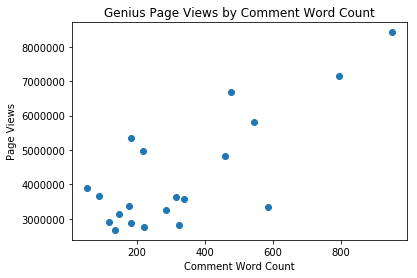

In [17]:
plt.scatter(df['comments_WordCount'],df['pageviews'])
plt.ylabel('Page Views')
plt.xlabel('Comment Word Count')
plt.title('Genius Page Views by Comment Word Count')